Sheet 4.1: Non-linear regression (custom MLP)
=============================================

**Author:** Michael Franke



In this tutorial, we will fit a non-linear regression, implemented as a multi-layer perceptron.
First, we will implement it the hard way: coding the different layers in terms of explicitly spelled out matrix operations.
In the next worksheet, we will see how the use of modules from PyTorch&rsquo; neural network package \`torch.nn\` helps us implement the model in a more efficient way.
Going through the model entirely by hand, helps understand what is happening &rsquo;under the hood&rsquo; and also helps appreciating the high-level functionality provided by software like PyTorch.



## Packages & global parameters



We will need to import the \`torch\` package for the main functionality.
We specifically import the neural network functionalities from PyTorch as \`nn\`.
We use this here only for the training loss function (MSE).
In order to have a convenient handle, we load the \`torch.nn.functional\` package into variable \`F\`.
We use this to pick up the activation function (ReLU) we will use for our neural network.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# import sys
import warnings
warnings.filterwarnings('ignore')

We will also globally set the float precision to 64:



In [1]:
torch.set_default_dtype(torch.float64)

## True model



The &ldquo;true model&rdquo; is a constructed non-linear function $y = f(x)$.
Here is its definition and a plot to show what the &ldquo;ground truth&rdquo; looks like.



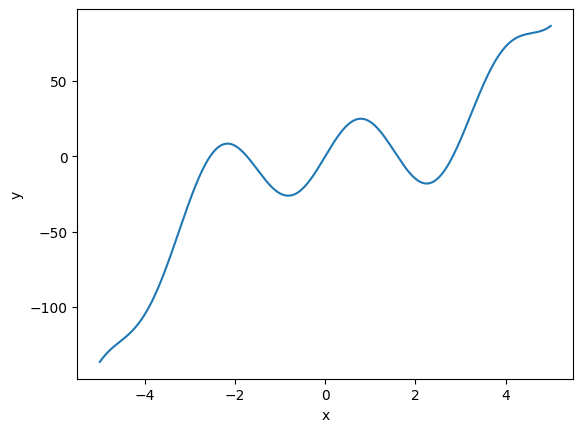

In [1]:
##################################################
## ground-truth model
##################################################

def goalFun(x):
    return(x**3 - x**2 + 25 * np.sin(2*x))

# create linear sequence (x) and apply goalFun (y)
x = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x)

# plot the function
d = pd.DataFrame({'x' : x, 'y' : y})
sns.lineplot(data = d, x = 'x', y = 'y')
plt.show()

## Training data



The training data consists of 100 pairs of  $(x,y)$ values.
Each pair is generated by first sampling an $x$ value from a uniform distribution.
For each sampled $x$, we compute the value of the target function $f(x)$ and add Gaussian noise to it.



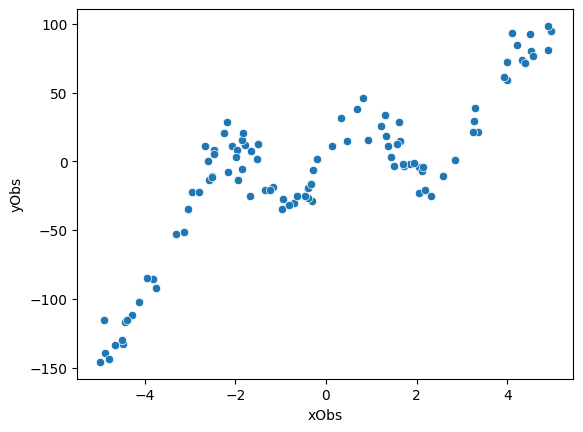

In [1]:
##################################################
## generate training data (with noise)
##################################################

nObs = 100 # number of observations

# get noise around y observations
yNormal = torch.distributions.Normal(loc=0.0, scale=10)
yNoise  = yNormal.sample([nObs])

# get observations
xObs = 10*torch.rand([nObs])-5    # uniform from [-5,5]
yObs = xObs**3 - xObs**2 + 25 * torch.sin(2*xObs) + yNoise

# plot the data
d = pd.DataFrame({'xObs' : xObs, 'yObs' : yObs})
sns.scatterplot(data = d, x = 'xObs', y = 'yObs')
plt.show()

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 4.1.1: Explore the training data</span></strong>
>
> 1. Remove the noise in the data by changing a single number (parameter value).
> 2. At what point is the noise in the data so large that there is nothing more to learn?



## Hand-coding a multi-layer perceptron



Our model maps a single real number $x$ onto another single real number $y$.
We therefore have a neural network whith input and output dimension set to 1.
In between $x$ and $y$, we will use three hidden layers $h_{1}, h_{2}, h_{3}$ each with dimension 10:



In [1]:
##################################################
## network dimension parameters
##################################################

nInput  = 1
nHidden = 10
nOutput = 1

The networks parameters are four matrices and four slopes.
The first embedding is called $U$, the following two hidden-to-hidden transformations are $V_{1}$ and $V_{2}$, the hidden-to-output mapping is given by matrix $W$.



In [1]:
##################################################
## trainable (matrix & slope) parameters
##           --initializing weights --
##################################################

U  = torch.tensor(np.random.rand(nHidden,nInput)   * 2 - 1,
                  requires_grad=True)
V1 = torch.tensor(np.random.rand(nHidden, nHidden) * 2 - 1,
                  requires_grad=True)
V2 = torch.tensor(np.random.rand(nHidden, nHidden) * 2 - 1,
                  requires_grad=True)
W  = torch.tensor(np.random.rand(nOutput, nHidden) * 2 - 1,
                  requires_grad=True)
b1 = torch.zeros((nHidden,1), requires_grad=True)
b2 = torch.zeros((nHidden,1), requires_grad=True)
b3 = torch.zeros((nHidden,1), requires_grad=True)

Next, we will define the forward pass.



In [1]:
##################################################
## forward pass
##################################################

activationFun = F.relu # use ReLU fct from PyTorch

# this function takes a /single/ observation for x as input
#   and it outputs a /single/ observation for y
#   we will NOT use this one, but include for better understanding
def singleForwardPass(x):
    h1 = activationFun(U*x + b1)
    h2 = activationFun(torch.mm(V1,h1) + b2)
    h3 = activationFun(torch.mm(V2,h2) + b3)
    y  = torch.mm(W,h3)
    return(y[0,0])

# this function takes a /vector/ of observations for x as input
#   and it outputs a /vector/ of observations for y
#   we will use this function as it is massively more efficient in training
def singleForwardPassBatched(xObs):
    xObsBatched = xObs.reshape(100,1,1)       # 100 1x1 matrices
    h1 = activationFun(U @ xObsBatched + b1)  # 100 column vectors
    h2 = activationFun(V1 @ h1 + b2)
    h3 = activationFun(V2 @ h2 + b3)
    y  = W @ h3
    yReshaped = torch.reshape(y,(-1,))
    return(yReshaped)

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 4.1.2: Digest the model, the parameters and their initialization</span></strong>
>
> 1. Verify that the functions &rsquo;singleForwardPass&rsquo; and &rsquo;singleForwardPassBatched&rsquo; do the same thing by comparing their predictions for the whole sequence of &rsquo;xObs&rsquo;.
> I.e., simply call &rsquo;singleForwardPassBatched&rsquo; and compare the output to calls of &rsquo;singleForwardPass&rsquo;.
> Ideally, produce outputs from &rsquo;singleForwardPass&rsquo; for all elements of &rsquo;xObs&rsquo; by list-comprehension.
>
> 2. Write down this model (forward pass) in mathematical notation. (The mathematical formulation of the model should follow the &rsquo;singleForwardPass&rsquo;).
>
> 3. Describe the way parameters are initialized (above) in your own intuitive terms?
>
> 4. Why can we not just set all parameter values to 0 initially?

It remains to instantiate an optimizer and to run execute the training loop.

Next, we will define the &rsquo;forward pass&rsquo;, i.e., a function that computes the predicted $y$ for a given input $x$ based on the current model parameters.



#+begin_example


Iteration:     0 | Loss:       3134.0
Iteration:  5000 | Loss:        993.0
Iteration: 10000 | Loss:        539.0
Iteration: 15000 | Loss:        149.0
Iteration: 20000 | Loss:        103.0
Iteration: 25000 | Loss:         99.0
Iteration: 30000 | Loss:         96.0
Iteration: 35000 | Loss:         95.0
Iteration: 40000 | Loss:         95.0
Iteration: 45000 | Loss:         95.0
Iteration: 50000 | Loss:         95.0
Iteration: 55000 | Loss:         94.0
Iteration: 60000 | Loss:         93.0
Iteration: 65000 | Loss:         91.0
Iteration: 70000 | Loss:         89.0
Iteration: 75000 | Loss:         89.0
Iteration: 80000 | Loss:         89.0
Iteration: 85000 | Loss:         88.0
Iteration: 90000 | Loss:         87.0
Iteration: 95000 | Loss:         87.0
Iteration: 100000 | Loss:         87.0
#+end_example

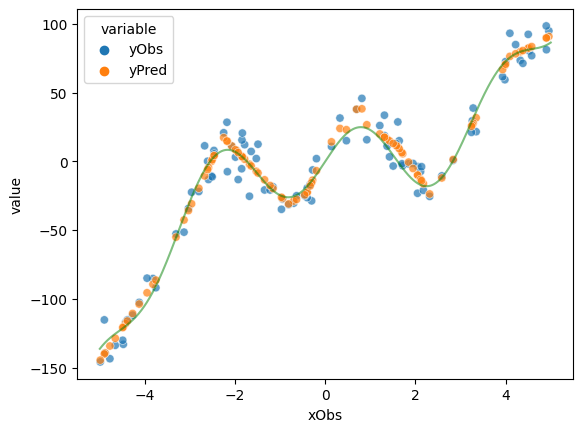

In [1]:
##################################################
## optimizer & training loop
##################################################

# initialize optimizer: Adam optimizer
loss_function = nn.MSELoss()
opt = torch.optim.Adam([U,V1,V2,W,b1,b2,b3], lr=1e-4)

epochs = 100000
for i in range(epochs+1):
    if (i == 0):
        print("\n")
    yPred = singleForwardPassBatched(xObs)
    loss  = loss_function(yPred, yObs)
    # loss  = torch.mean((yPred - yObs)**2)
    if (i == 0 or i % 5000 == 0):
        print('Iteration: {:5d} | Loss: {:12}'.format(i, loss.detach().numpy().round(0)))
        # print("Iteration: ", i, " Loss: ", loss.detach().numpy())
    loss.backward()
    opt.step()
    opt.zero_grad()

yPred = singleForwardPassBatched(xObs)

# plot the data
d = pd.DataFrame({'xObs' : xObs.detach().numpy(),
                  'yObs' : yObs.detach().numpy(),
                  'yPred': yPred.detach().numpy()})
dWide = pd.melt(d, id_vars = 'xObs', value_vars= ['yObs', 'yPred'])
sns.scatterplot(data = dWide, x = 'xObs', y = 'value', hue = 'variable', alpha = 0.7)
x = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x)
plt.plot(x,y, color='g', alpha = 0.5)
plt.show()

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 4.1.3: Inspecting and interpreting the model fit</span></strong>
>
> 0. [just for yourself] Make sure that you understand all ingredients and steps used here. Read up on the MSE loss function, for instance, or ask if you are unsure.
>
> 1. Inspect the print-outs from the training sequence. Does this output suggest that the training was successful or not?
>
> 2. What does the plot produced here after training show exactly? Does that picture suggest that the model learned successfully? Do you think that there might even be a sense in which the model &ldquo;[overfitted](https://en.wikipedia.org/wiki/Overfitting)&rdquo; the data?
>
> 3. Change the optimizer to vanilla Gradient Descent (&rsquo;SGD&rsquo;), change the training rate to &rsquo;lr=1e-6&rsquo; and the number of training epochs to &rsquo;epochs = 50000&rsquo;.
> Now, (first re-initialize all parameter values to start training anew) and repeatedly execute the last code cell (probably 4-6 times).
> Describe what you observe by answering the following questions:
> (i) is training with &rsquo;SGD&rsquo; more or less efficient than the initial set-up?;
> (ii) why is it more/less efficient?
> (iii) if we think of training the model as &ldquo;curve fitting&rdquo;, which parts of the curve are adapted first, which ones later?
> (iv) explain the difference you described in (iii).

